In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
# library imports
import os
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import PIL 

In [ ]:
# data loading
image_dir = Path('/content/mydrive/MyDrive/Notebooks/Lumpy Skin/Lumpy Skin Images Dataset/dataset_og')

# get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

# generating text file for annotations
unique_list = image_df['Label'].unique().tolist()
classes = len(unique_list)

with open('/content/mydrive/MyDrive/Notebooks/Lumpy Skin/Lumpy Skin Images Dataset/annotations.txt', 'w') as filehandle:
    for listitem in unique_list:
        filehandle.write('%s\n' % listitem)

In [ ]:
classes

2

In [ ]:
# shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# show the result
image_df.head()

,Filepath,Label
0,/content/mydrive/MyDrive/Notebooks/Lumpy Skin/...,Lumpy Skin
1,/content/mydrive/MyDrive/Notebooks/Lumpy Skin/...,Normal Skin
2,/content/mydrive/MyDrive/Notebooks/Lumpy Skin/...,Normal Skin
3,/content/mydrive/MyDrive/Notebooks/Lumpy Skin/...,Normal Skin
4,/content/mydrive/MyDrive/Notebooks/Lumpy Skin/...,Normal Skin


In [ ]:
image_df['Label'].unique

<bound method Series.unique of 0        Lumpy Skin
1       Normal Skin
2       Normal Skin
3       Normal Skin
4       Normal Skin
           ...     
1019    Normal Skin
1020     Lumpy Skin
1021    Normal Skin
1022    Normal Skin
1023     Lumpy Skin
Name: Label, Length: 1024, dtype: object>

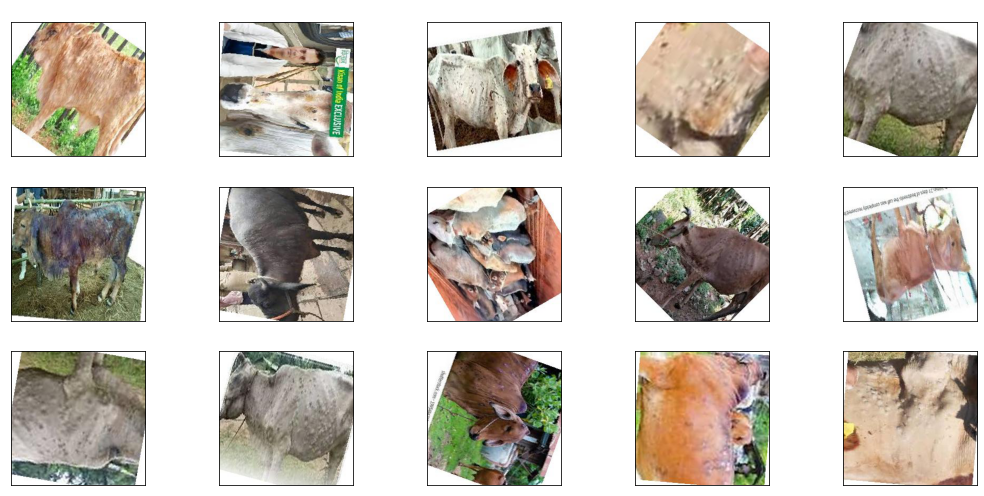

In [ ]:
# display 15 picture of the dataset with their labels
from turtle import color

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for b, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[b]))
    ax.set_title(image_df.Label[b], color='white')
plt.tight_layout()
plt.show()

In [ ]:
# separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=180,
    fill_mode='nearest'
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 737 validated image filenames belonging to 2 classes.
Found 184 validated image filenames belonging to 2 classes.
Found 103 validated image filenames belonging to 2 classes.


In [ ]:
# loading the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max',
    classes=2
)

pretrained_model.trainable = False

In [ ]:
# model architecture & training
inputs = pretrained_model.input

x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20)
# callbacks=[
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         patience=1,
#         restore_best_weights=True
#     )
# ]

Epoch 1/20
24/24 [==============================] - 35s 1s/step - loss: 0.9123 - accuracy: 0.6445 - val_loss: 0.7058 - val_accuracy: 0.5272
Epoch 2/20
24/24 [==============================] - 13s 531ms/step - loss: 0.6240 - accuracy: 0.6879 - val_loss: 0.6553 - val_accuracy: 0.6467
Epoch 3/20
24/24 [==============================] - 13s 535ms/step - loss: 0.3512 - accuracy: 0.8521 - val_loss: 0.5166 - val_accuracy: 0.8043
Epoch 4/20
24/24 [==============================] - 13s 536ms/step - loss: 0.3500 - accuracy: 0.8521 - val_loss: 0.3130 - val_accuracy: 0.9130
Epoch 5/20
24/24 [==============================] - 13s 537ms/step - loss: 0.3983 - accuracy: 0.8195 - val_loss: 0.3688 - val_accuracy: 0.8261
Epoch 6/20
24/24 [==============================] - 13s 547ms/step - loss: 0.3804 - accuracy: 0.8331 - val_loss: 0.3040 - val_accuracy: 0.9076
Epoch 7/20
24/24 [==============================] - 13s 552ms/step - loss: 0.3271 - accuracy: 0.8643 - val_loss: 0.3718 - val_accuracy: 0.8261
Ep

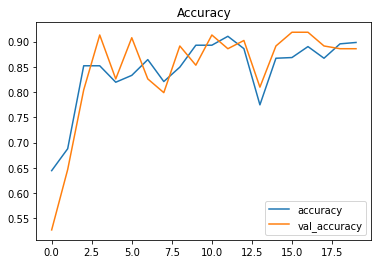

In [ ]:
# accuracy visualization
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

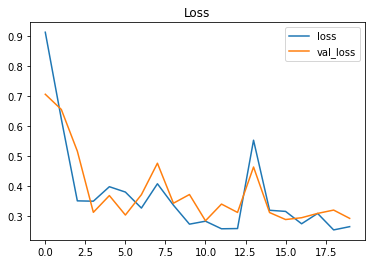

In [ ]:
# loss visualization
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
model.save('/content/mydrive/MyDrive/Notebooks/Lumpy Skin/Lumpy Skin Images Dataset/model/mobilenet')